## Modelado

El modelado de las series temporales nos sirve para realizar predicciones, estimaciones de valores futuros y preparar nuestros procesos en base a estos. Ejemplo: si realizamos la previsión de ventas de producto podemos actualizar el stock de cara a no quedarnos sin existencias.

Para ello deberemos ser capaces de evaluar la bondad de nuestras estimaciones y para ello emplearemos las métricas habituales...

- [R squared](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination): coeficiente de determinación, $(-\infty, 1]$

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$ 

```python
sklearn.metrics.r2_score
```
---
- [Mean Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error): error que emplea el mismo nivel de unidad que nuestros datos, $[0, +\infty)$

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$ 

```python
sklearn.metrics.mean_absolute_error
```
---
- [Median Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error):algo más robusto a los valores anómalos que el MAE, $[0, +\infty)$

$MedAE = median(|y_1 - \hat{y}_1|, ... , |y_n - \hat{y}_n|)$

```python
sklearn.metrics.median_absolute_error
```
---
- [Mean Squared Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error): penaliza más los valores altos, muy utilizado, $[0, +\infty)$

$MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$

```python
sklearn.metrics.mean_squared_error
```
---
- [Mean Squared Logarithmic Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error): con datos que muestran una tendencia exponencial nos permite penalizar valores muy pequeños también, $[0, +\infty)$

$MSLE = \frac{1}{n}\sum\limits_{i=1}^{n} (log(1+y_i) - log(1+\hat{y}_i))^2$

```python
sklearn.metrics.mean_squared_log_error
```
---
- Mean Absolute Percentage Error: equivalente al MAE pero mostrado de forma porcentual, $[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 

```python
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
```

Adicionalmente deberemos tener en cuenta ciertos criterios considerados por el modelado en series temporales.

### AIC

Akaike’s Information Criterion

![imagen](./img/aic.png)

$k$ es el número de parámetros del modelo estadístico y $L$ es el máximo valor de la función de verosimilitud para el modelo estimado. La función de verosimilitud permite realizar inferencias a partir de u conjunto de observaciones.

Se utiliza para seleccionar el mejor modelo, que será el que tiene menor AIC. El AIC depende mucho de cada dato, y es una medida de comparación entre modelos, no de presentación de resultados. Un AIC bajo no quiere decir que el modelo sea muy bueno. Por tanto, AIC no nos dice nada sobre la calidad del modelo en términos absolutos.

### BIC

El Criterio de Información Bayesiano (BIC) es un método estadístico para evaluar la calidad relativa de modelos entre un conjunto finito de opciones. Se basa en la función de probabilidad y está estrechamente relacionado con el Criterio de Información de Akaike (AIC).

## Análisis inicial

Vamos a utilizar los datos de ventas de Johnson&Johnson

In [1]:
import pandas as pd

data = pd.read_csv('data/a10.csv', index_col=0, parse_dates=['date'])
print("Tamaño de la serie ", len(data))
data.head()

Tamaño de la serie  204


,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


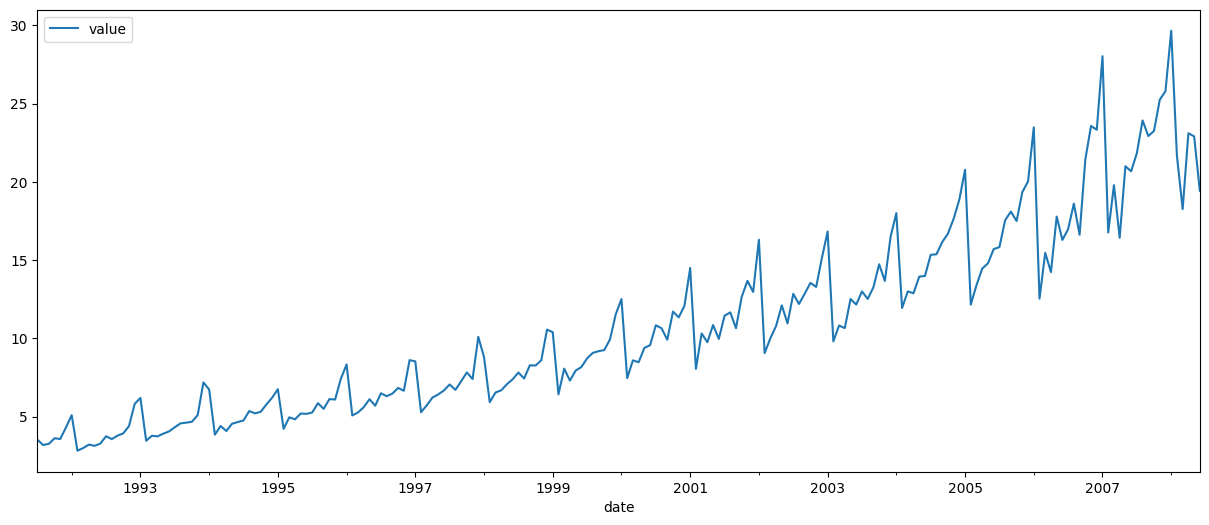

In [2]:
data.plot(figsize=(15,6));

Se aprecia en la gráfica que presenta diferentes estadísticos a lo largo del tiempo. Sabemos que esto va a ser un gran limitante dado que la estacionariedad de la serie es un factor clave a la hora de disponer un buen estimador.

In [3]:
from statsmodels.tsa.stattools import adfuller

stat, pval, usedlag, nobs,crtivals, icbest = adfuller(data.values)
print(pval)

1.0


La hipótesis nula de Dickey-Fuller aumentado es que hay una raíz unitaria, con la alternativa de que no hay raíz unitaria. Si el valor p está por encima de un tamaño crítico, entonces no podemos rechazar que exista una raíz unitaria.

Los p-valores se obtienen mediante la aproximación de superficie de regresión de MacKinnon 1994, pero utilizando las tablas actualizadas de 2010. Si el valor p está cerca de ser significativo, entonces los valores críticos deben utilizarse para juzgar si se rechaza la nulidad. La opción autolag y maxlag para ella se describen en Greene.

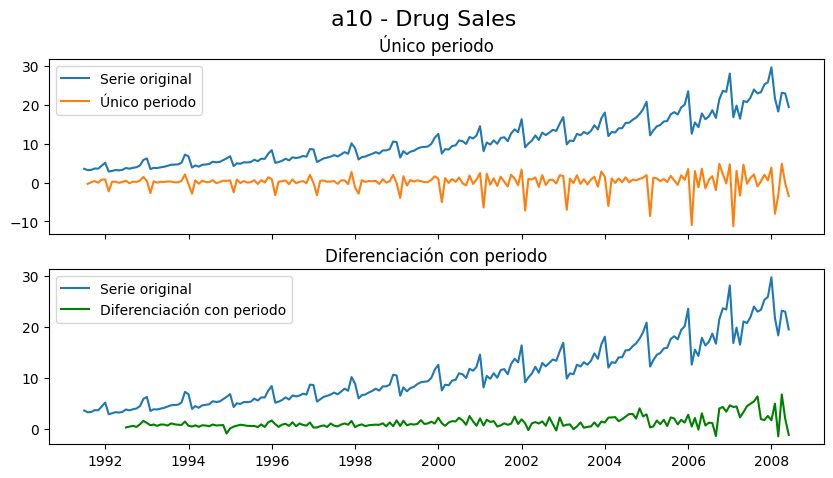

In [4]:
import matplotlib.pyplot as plt

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Diferencia usual
axes[0].plot(data[:], label='Serie original')
axes[0].plot(data[:].diff(1), label='Único periodo')
axes[0].set_title('Único periodo')
axes[0].legend(loc='upper left', fontsize=10)

# Estacionalidad
axes[1].plot(data[:], label='Serie original')
axes[1].plot(data[:].diff(12), label='Diferenciación con periodo', color='green')
axes[1].set_title('Diferenciación con periodo')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('a10 - Drug Sales', fontsize=16)
plt.show()

In [5]:
# Con diferenciación de segundo orden
stat, pval, usedlag, nobs,crtivals, icbest = adfuller(data.diff(12).diff(12).dropna().values)
print(pval)

0.00011730556082591406


# División en train y test

A diferencia de las muestras independientes, en el caso de las series temporales es importante realizar los tests con el último bloque de la serie.

In [6]:
X = data.values
train = X[:150]
test = X[150:]

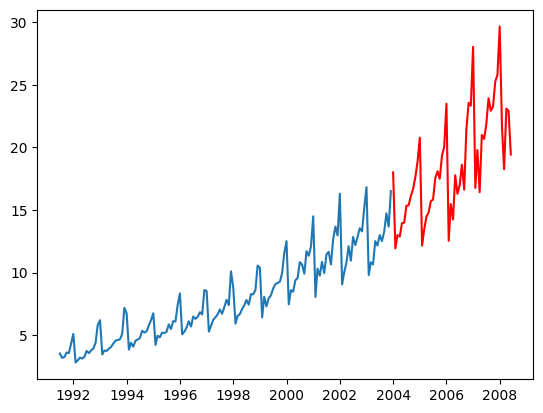

In [7]:
import matplotlib.pyplot as plt

plt.plot(data.index[:150], train)
plt.plot(data.index[150:], test, color='r')

## Modelo autoregresivo

El Modelo Autoregresivo (AR) es un tipo de modelo estadístico que predice valores futuros basados solo en los valores pasados. Se caracteriza por ser un modelo lineal, donde el valor actual se expresa como una suma de valores pasados multiplicados por un factor numérico.

**Estructura del Modelo AR**
El Modelo AR se denota como AR(p), donde “p” es el orden del modelo y representa el número de valores pasados que se incluyen en la predicción. La fórmula general es:
$$
y_t = \beta_0 + \beta_1 y_{t-1} + \beta_2 y_{t-2} + \dots + \beta_p y_{t-p} + \epsilon

$$

Por lo tanto, tendremos que encontrar el orden de autoregression que mejor encaje con nuestros datos. Cuantos $p$ debemos tener en cuenta hacia atrás.

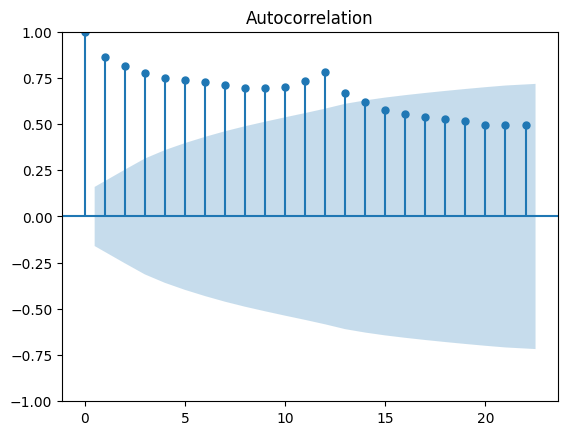

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(train);

In [9]:
from statsmodels.tsa.ar_model import AutoReg

# AR(1)
mod = AutoReg(train, 1)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  150
Model:                     AutoReg(1)   Log Likelihood                -274.183
Method:               Conditional MLE   S.D. of innovations              1.524
Date:                Tue, 23 Jul 2024   AIC                            554.366
Time:                        15:47:06   BIC                            563.378
Sample:                             1   HQIC                           558.028
                                  150                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8206      0.321      2.557      0.011       0.192       1.450
y.L1           0.9058      0.038     23.868      0.000       0.831       0.980
                                    Roots           

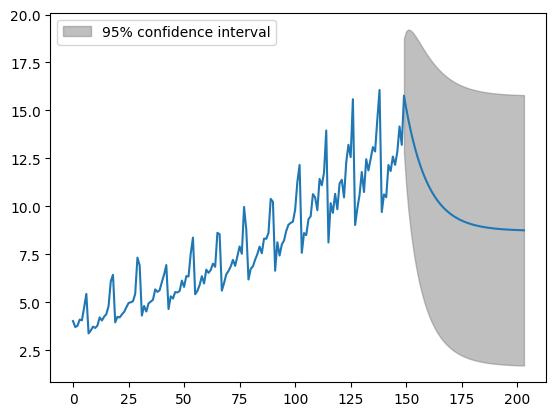

In [10]:
fig = res.plot_predict(1, len(data))

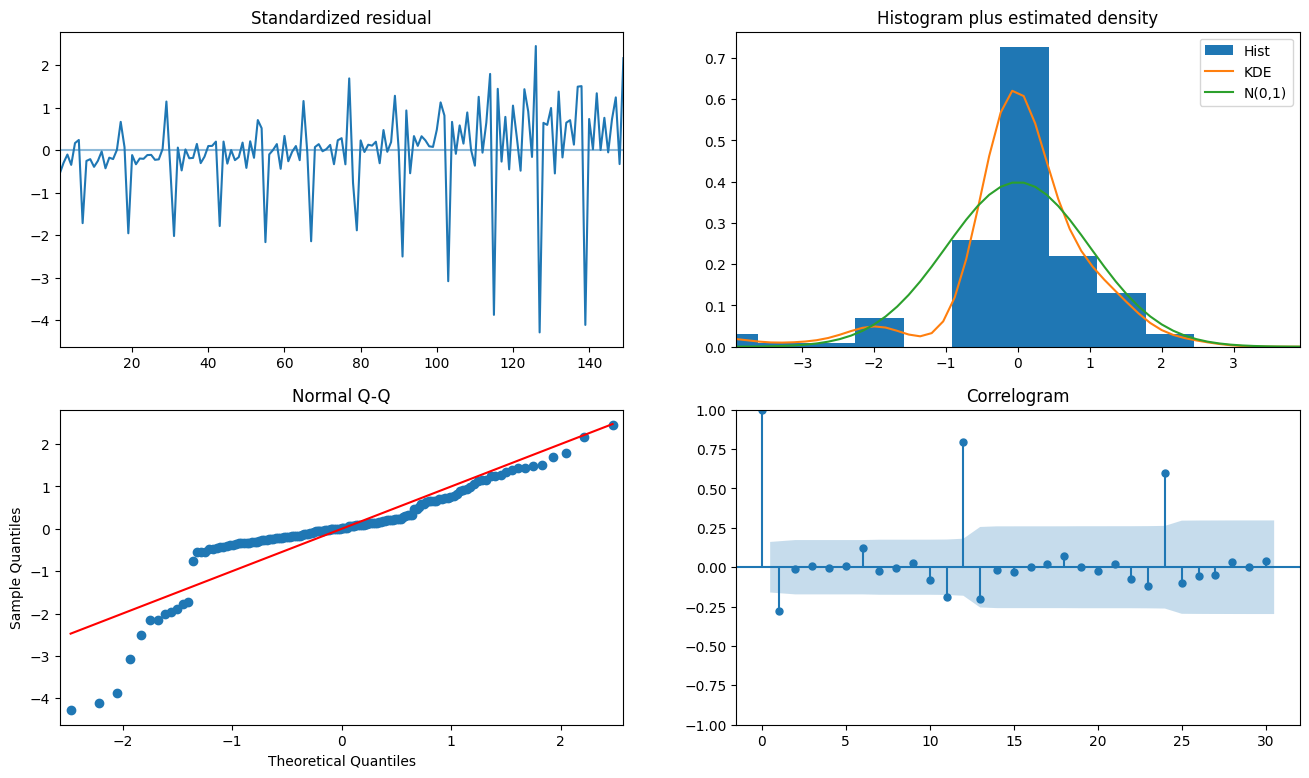

In [11]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

¿Qué vemos en el gráfico?

* Los residuos deberían mostrarse con media cero y varianza uniforme.
* El plot de densidad debería corresponder a una serie normal.
* Todos los puntos deberían caer en la línea roja, si no la distribución será asimétrica.
* No debería haber correlación entre los residuos, si no es que nos hemos dejado algo al modelar.

No parece que de buen resultado el AR(1). Probemos diferentes lags, a ver cuál sería el mejor

In [12]:
lag = int(input("Número de lags"))

mod = AutoReg(train, lag)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  150
Model:                    AutoReg(12)   Log Likelihood                -102.393
Method:               Conditional MLE   S.D. of innovations              0.508
Date:                Tue, 23 Jul 2024   AIC                            232.787
Time:                        15:47:08   BIC                            273.768
Sample:                            12   HQIC                           249.441
                                  150                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4656      0.126      3.695      0.000       0.219       0.713
y.L1           0.0304      0.035      0.874      0.382      -0.038       0.099
y.L2           0.0076      0.035      0.219      0.8

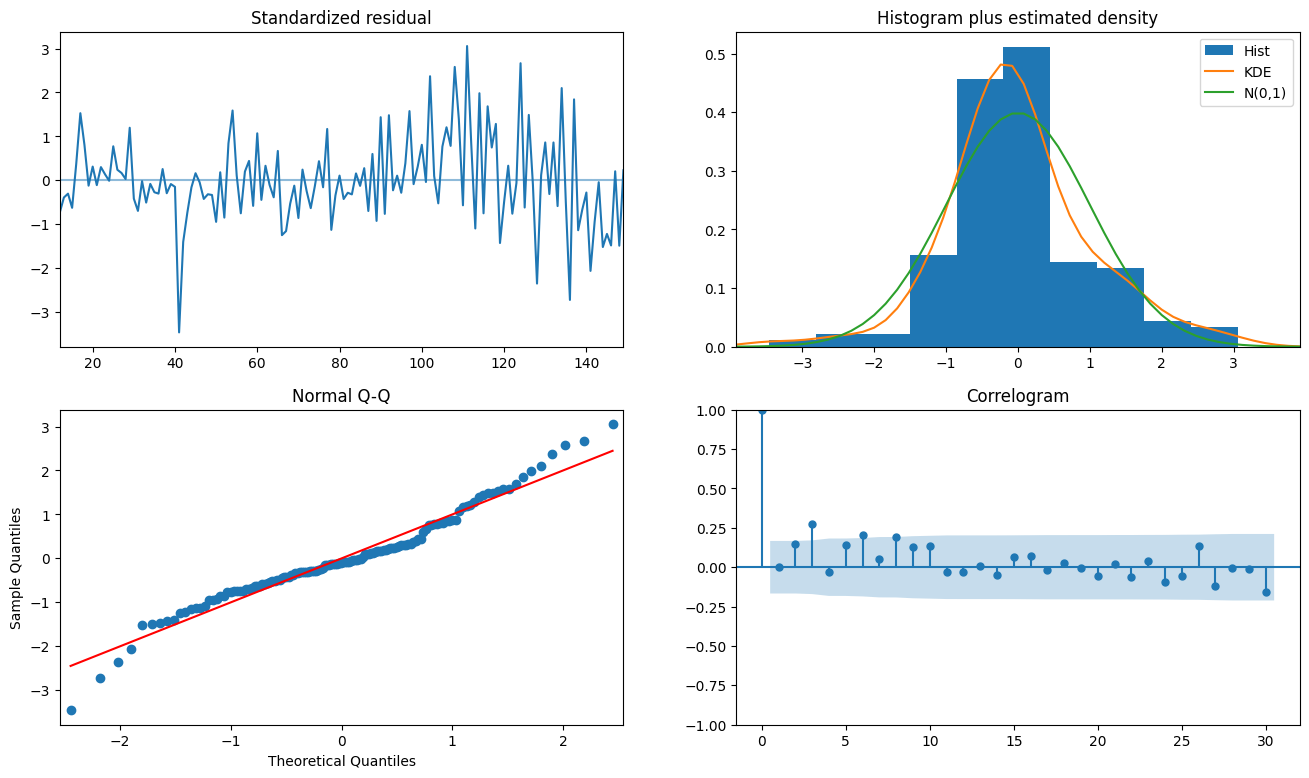

In [13]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

Un parámetro cercano a 12 parece que da buen resultado, pero aun asi es muy alto el error.

## Moving Average

La media móvil (MA) es un proceso en el que el valor actual de una serie temporal, y, se define como una combinación lineal de errores pasados. El término de error (ruido) se representa como $e$. Tanto $t-1$ como $t-2$ son retardos temporales de los errores.

MA(1) model: $y_{t}$ = $m_{1}$ $e_{t-1}$ + $e_{t}$

MA(2) model: $y_{t}$ = $m_{1}$ $e_{t-1}$ + $m_{2}$ $e_{t-2}$ + $e_{t}$

La media móvil nos puede ayudar a eliminar la componente de tendencia a la hora de hacer nuestras estimaciones.

In [14]:
train = train.reshape(-1)

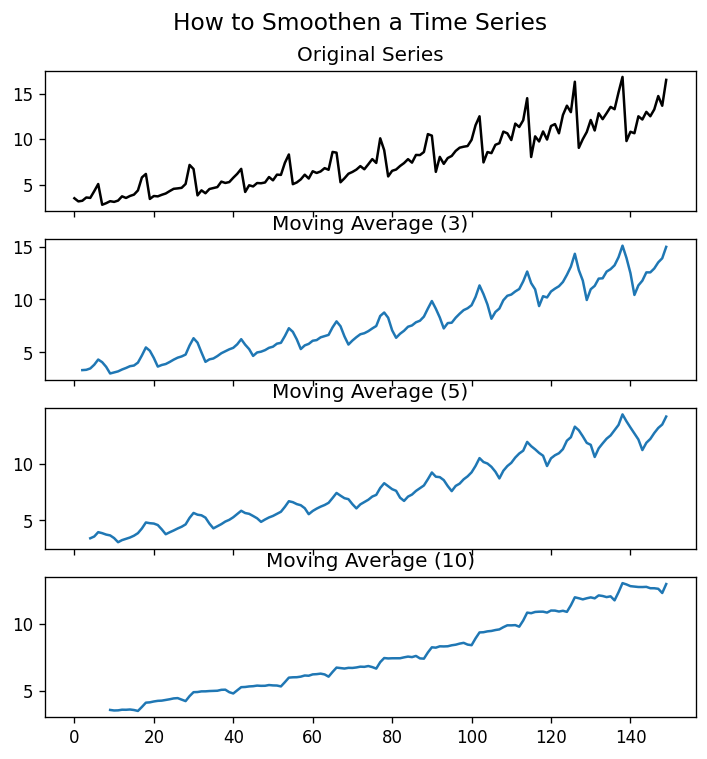

In [15]:
# Moving Average
df_ma = pd.Series(train).rolling(3).mean()
df_ma_5 = pd.Series(train).rolling(5).mean()
df_ma_10 = pd.Series(train).rolling(10).mean()

# Plot
fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)
pd.Series(train).plot(ax=axes[0], color='k', title='Original Series')
df_ma.plot(ax=axes[1], title='Moving Average (3)')
df_ma_5.plot(ax=axes[2], title='Moving Average (5)')
df_ma_10.plot(ax=axes[3], title='Moving Average (10)')
fig.suptitle('How to Smoothen a Time Series', y=0.95, fontsize=14)
plt.show()

Armado con nuestros dos modelos, podemos realizar un modelo ARMA que combina ambas técnicas en un único estimador.

In [16]:
# !pip install pmdarima

In [17]:
import warnings

warnings.filterwarnings(action="ignore")

In [18]:
from pmdarima.arima import ARIMA

model_ma = ARIMA(order = (2,0,5))
model_ma.fit(train)

ARIMA(order=(2, 0, 5))

In [19]:
from sklearn.metrics import mean_squared_error

predictions = model_ma.predict(len(test))
print("mean_squared_error:", mean_squared_error(test, predictions))

mean_squared_error: 51.15423191594397


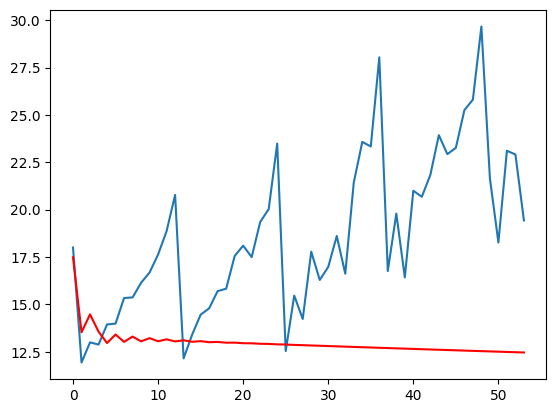

In [20]:
plt.plot(test)
plt.plot(predictions,color='red');

No está dando buen resultado. Probaremos entonces varios lags aunque el hecho de que la serie no sea estacionaria puede darnos problemas.

## ARIMA
En el arima no solo influyen los parámetros `p` y `q`, sino que también tendremos en cuenta `d`. Parametro con el que diferenciaremos la serie y conseguiremos que sea estacionaria.

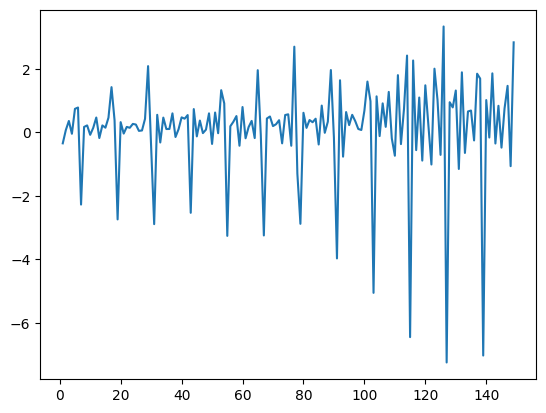

In [21]:
d = 1 # Cambiad d

diff = pd.Series(train)
for _ in range(d):
    diff = diff.diff()
plt.plot(diff)
plt.show()

In [22]:
adfuller(diff.dropna())[1]

0.0032340609855731704

Ahora bien, ¿cuál es la mejor combinación de parámetros? Tendremos que realizar varias pruebas. Para comparar los modelos se suele utilizar el AIC.

#### ¿Cómo conseguir los mejores p, d, q?

In [23]:
import itertools

p = range(0,5)
d = range(0,2)
q = range(0,5)
pdq = list(itertools.product(p,d,q))
pdq[:10]

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4)]

In [24]:
len(pdq)

50

In [25]:
import warnings
warnings.filterwarnings("ignore")

results = []
for param in pdq:
    try:
        model_arima = ARIMA(order=param)
        model_arima_fit = model_arima.fit(train)
        results.append((param,model_arima_fit.aic()))
    except:
        continue

In [26]:
resultados_df = pd.DataFrame(results, columns=['ARIMA params', 'AIC']).sort_values('AIC')
resultados_df.head()

,ARIMA params,AIC
47,"(4, 1, 2)",483.553224
48,"(4, 1, 3)",485.397146
38,"(3, 1, 3)",488.515524
39,"(3, 1, 4)",499.113621
49,"(4, 1, 4)",499.761771


In [27]:
len(resultados_df)

50

Ya tenemos la mejor combinación de parámetros para el ARIMA. Probemos el modelo

In [28]:
best_model = ARIMA(order=(4,1,2))
best_model.fit(train)

ARIMA(order=(4, 1, 2))

In [29]:
best_model.predict(14)

array([14.38201162, 13.47746736, 13.04056982, 12.59138577, 12.62958027,
       12.97463579, 13.45240119, 13.95781424, 14.36655847, 14.61325109,
       14.69332072, 14.64264437, 14.52259012, 14.39817181])

In [30]:
predictions = best_model.predict(len(test))
print("mean_squared_error:", mean_squared_error(test, predictions))

mean_squared_error: 21.955436859866335


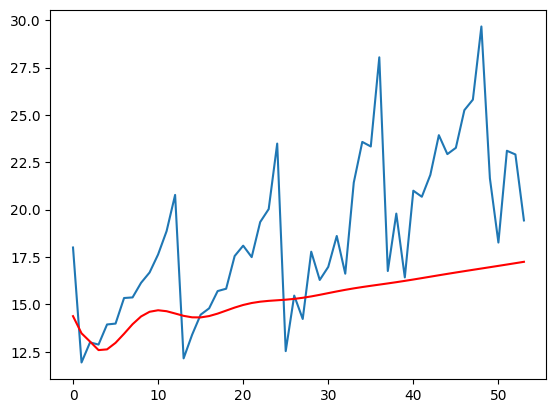

In [31]:
plt.plot(test)
plt.plot(predictions,color='red');

### Auto ARIMA

Auto ARIMA nos permite incluir aspectos como valores máximos y mínimos para los parámetros base (p, q y d), si necesitamos incluir modelado estacional, número de periodos que cubre cada componente estacional, etc. Disponéis de toda la información en la documentación oficial: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html#pmdarima.arima.auto_arima 

In [32]:
from pmdarima.arima import auto_arima

smodel = auto_arima(data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=534.818, Time=1.06 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=624.061, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=596.068, Time=0.30 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=611.475, Time=0.22 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=757.274, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=559.407, Time=0.09 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.30 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=536.817, Time=2.29 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=543.106, Time=0.43 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=537.550, Time=3.23 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=594.467, Time=0.14 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=529.829, Time=0.72 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=555.198, Time=0.12 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.42 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AI

In [33]:
smodel

ARIMA(order=(1, 0, 2), scoring_args={}, seasonal_order=(1, 1, 2, 12),
      suppress_warnings=True)

In [34]:
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(1, 0, 2)x(1, 1, 2, 12)   Log Likelihood                -253.981
Date:                            Tue, 23 Jul 2024   AIC                            523.961
Time:                                    15:48:39   BIC                            550.021
Sample:                                07-01-1991   HQIC                           534.515
                                     - 06-01-2008                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0050      0.009      0.559      0.576      -0.012       0.022
ar.L1          0.9767      0.018     53.181      0.000       0.941       1.013
ma.L1         -0.9027      0.056    -16.177      0.000      -1.012      -0.793
ma.L2          0.2116      0.058      3.671      0.000       0.099       0.325
ar.S.L12       0.8454      0.164      5.170      0.000       0.525       1.166
ma.S.L12      -1.5746      0.184     -8.563      0.000      -1.935      -1.214
ma.S.L24       0.7503      0.112      6.685      0.000       0.530       0.970
sigma2         0.7445      0.063     11.782      0.000       0.621       0.868
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):               143.33
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):              14.58   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

In [36]:
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

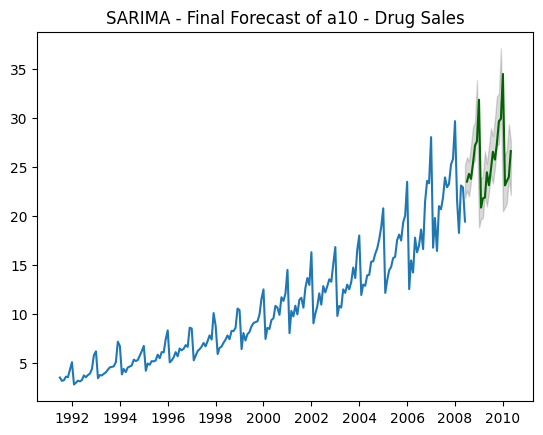

In [37]:
# Plot
plt.plot(data)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()

## ARIMAX

La $X$ viene de exogenous. Significa que le podemos añadir una variable externa con la que entrenar el modelo.

Tomaremos los datos de mercado de Facebook para realizar un ejercicio con variables exógenas.

In [38]:
data = pd.read_csv("data/FB.csv")
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-12-08,76.180000,77.250000,75.400002,76.519997,76.519997,25733900
1,2014-12-09,75.199997,76.930000,74.779999,76.839996,76.839996,25358600
2,2014-12-10,76.650002,77.550003,76.070000,76.180000,76.180000,32210500
3,2014-12-11,76.519997,78.519997,76.480003,77.730003,77.730003,33462100
4,2014-12-12,77.160004,78.879997,77.019997,77.830002,77.830002,28091600
...,...,...,...,...,...,...,...
1254,2019-12-02,202.130005,202.179993,198.050003,199.699997,199.699997,11503400
1255,2019-12-03,197.600006,198.929993,195.080002,198.820007,198.820007,11595300
1256,2019-12-04,200.000000,200.029999,198.050003,198.710007,198.710007,8456300
1257,2019-12-05,199.860001,201.289993,198.210007,199.360001,199.360001,9740400


<Axes: >

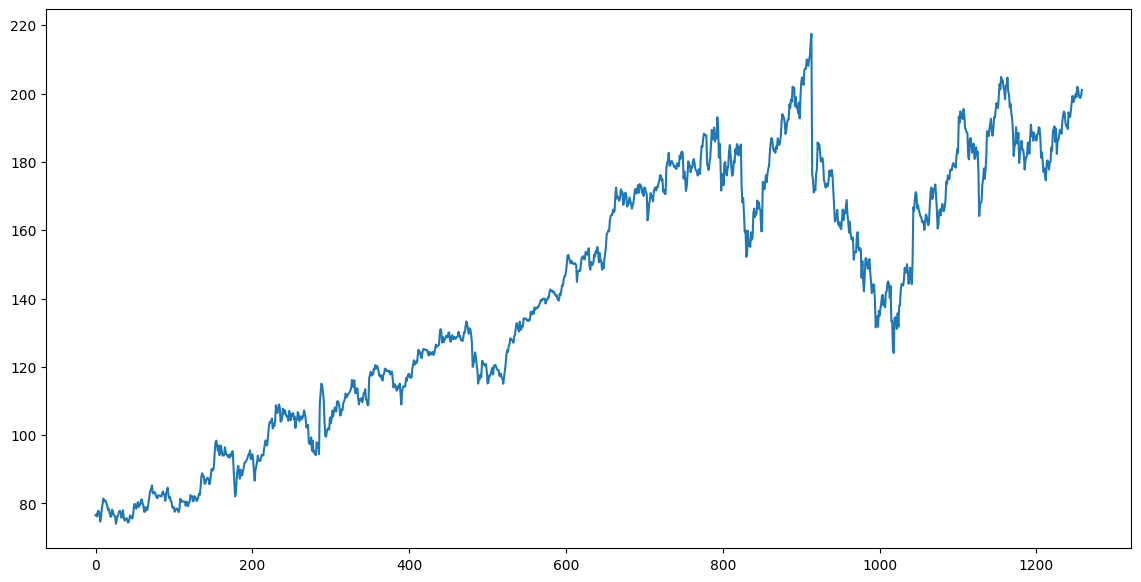

In [39]:
data.Close.plot(figsize=(14, 7))

Vemos primero ejemplo sin variable exogena

In [40]:
train = data.loc[:1200,'Close'].values
test = data.loc[1200:,'Close'].values

In [41]:
len(test)

59

Vamos a probar varios SARIMA, a ver cuál sería la mejor combinación de hiperparámetros.

In [42]:
stepwise_model = auto_arima(train,
                            start_p=1,
                            start_q=1,
                            max_d=10,
                            max_p=10,
                            max_q=10,
                            stationary=False,
                            trace=True,
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5784.133, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5786.083, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5787.923, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5787.915, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5785.466, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5785.452, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5785.477, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5789.205, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5789.260, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5786.323, Time=0.49 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5784.547, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.375 seconds
5784.132556469208


Ya lo tenemos, ahora montaremos el modelo con esos hiperparámetros y vemos que AIC tiene.

In [43]:
model = ARIMA(order=(1,1,1))
model.fit(train)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1201
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2888.066
Date:                Tue, 23 Jul 2024   AIC                           5784.133
Time:                        15:48:41   BIC                           5804.493
Sample:                             0   HQIC                          5791.802
                               - 1201                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0125      0.012      1.031      0.303      -0.011       0.036
ar.L1          0.8630      0.092      9.431      0.000       0.684       1.042
ma.L1         -0.8986      0.080    -11.215      0.0

In [44]:
predictions = model.predict(len(test))
print("mean_squared_error:", mean_squared_error(test, predictions))

mean_squared_error: 37.79426987402861


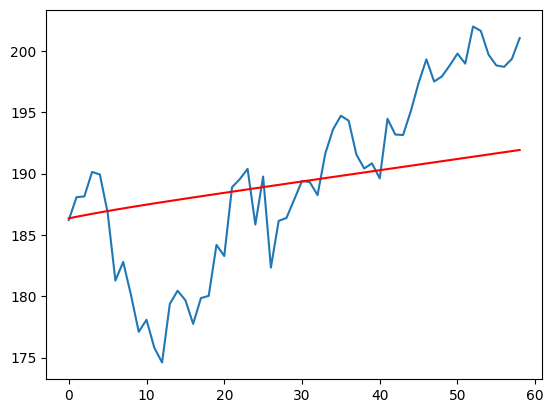

In [45]:
plt.plot(test)
plt.plot(predictions,color='red');

Vamos ahora a compararlo con el mismo modelo, pero en este caso le añadimos una variable exogena al entrenamiento

In [46]:
data.loc[:1200,['Close','Open']]

,Close,Open
0,76.519997,76.180000
1,76.839996,75.199997
2,76.180000,76.650002
3,77.730003,76.519997
4,77.830002,77.160004
...,...,...
1196,186.169998,187.440002
1197,188.490005,186.460007
1198,187.470001,189.860001
1199,187.190002,187.330002


In [47]:
model = ARIMA(order=(1,1,1))
model.fit(train, X = data.loc[:1200,['Open']])
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1201
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2501.845
Date:                Tue, 23 Jul 2024   AIC                           5013.690
Time:                        15:48:41   BIC                           5039.141
Sample:                             0   HQIC                          5023.277
                               - 1201                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.000      1.422      0.155      -0.000       0.001
Open           0.9971      0.003    371.956      0.000       0.992       1.002
ar.L1         -0.1302      0.024     -5.484      0.0

Probemos a entrenar el auto arima con la variable exogena

In [48]:
model = auto_arima(train,
                   X = data.loc[:1200,['Open']],
                   start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    stationary=False,
                    trace=True,
                    stepwise=True)

print(model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5005.630, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5027.971, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5008.695, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=5006.429, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5026.228, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=5007.497, Time=0.31 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=5005.972, Time=0.34 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=5006.240, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=5007.038, Time=0.41 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=5009.423, Time=0.57 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5003.637, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5004.411, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5006.718, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=5005.483, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]          

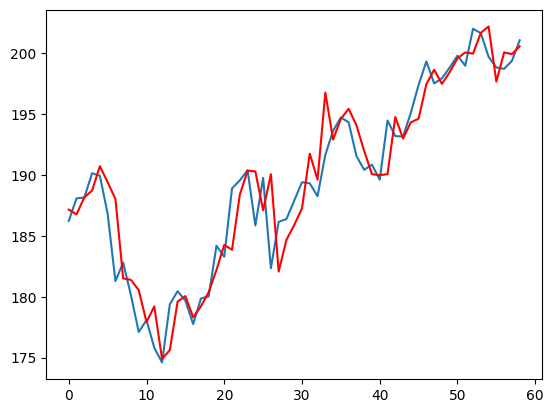

In [49]:
model = ARIMA(order=(1,0,1))
model.fit(train, X = data.loc[:1200,['Open']])
predictions = model.predict(len(test), X = data.loc[1200:,['Open']])

plt.plot(test)
plt.plot(range(len(test)), predictions.values, color='red');

Probemos varias variables exógenas

NOTA: para este apartado se utiliza el valor 'Low', que en la vida real no lo tendríamos para realizar la predicción.

In [251]:
model = auto_arima(train,
                   X = data.loc[:1200,['Open',"Low"]],
                   start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    stationary=False,
                    trace=True,
                    stepwise=True)

print(model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3942.822, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4582.845, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4307.506, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3948.437, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4581.144, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3936.535, Time=0.34 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4114.887, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3934.100, Time=0.51 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4052.014, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3935.312, Time=0.63 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3935.633, Time=0.74 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3936.309, Time=0.46 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=4028.084, Time=0.21 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3936.459, Time=0.89 sec
 ARIMA(3,1,1)(0,0,0)[0]          

In [252]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1201
Model:               SARIMAX(3, 1, 1)   Log Likelihood               -1959.050
Date:                Tue, 23 Jul 2024   AIC                           3934.100
Time:                        15:40:51   BIC                           3974.821
Sample:                             0   HQIC                          3949.439
                               - 1201                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0056      0.004      1.361      0.173      -0.002       0.014
Open          -0.0787      0.017     -4.769      0.000      -0.111      -0.046
Low            1.0295      0.015     68.544      0.000       1.000       1.059
ar.L1         -0.0933      0.028     -3.301      0.001      -0.149      -0.038
ar.L2         -0.0683      0.028     -2.458      0.014      -0.123      -0.014
ar.L3          0.0702      0.027      2.605      0.009       0.017       0.123
ma.L1         -0.9028      0.016    -58.012      0.000      -0.933      -0.872
sigma2         1.5306      0.048     31.715      0.000       1.436       1.625
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1166.66
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               2.75   Skew:                             1.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [256]:
model = ARIMA(order=(3,1,1))
model.fit(train, X = data.loc[:1200,['Open',"Low"]])
predictions = model.predict(len(test), X = data.loc[1200:,['Open',"Low"]])
print("mean_squared_error:", mean_squared_error(test, predictions))

mean_squared_error: 1.8298450562082547


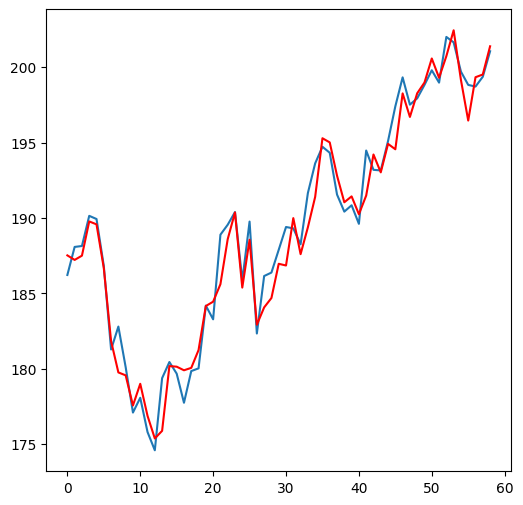

In [260]:
plt.plot(test)
plt.plot(range(len(test)), predictions.values, color='red');

## SARIMA
Veamos cómo podemos predecir con datos que tienen estacionalidad, es decir, que cuentan con un patrón que se repite a lo largo del tiempo.

In [261]:
df = pd.read_csv('data/a10.csv', parse_dates=['date'], index_col='date')
print(len(df))
df.head()

204


,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


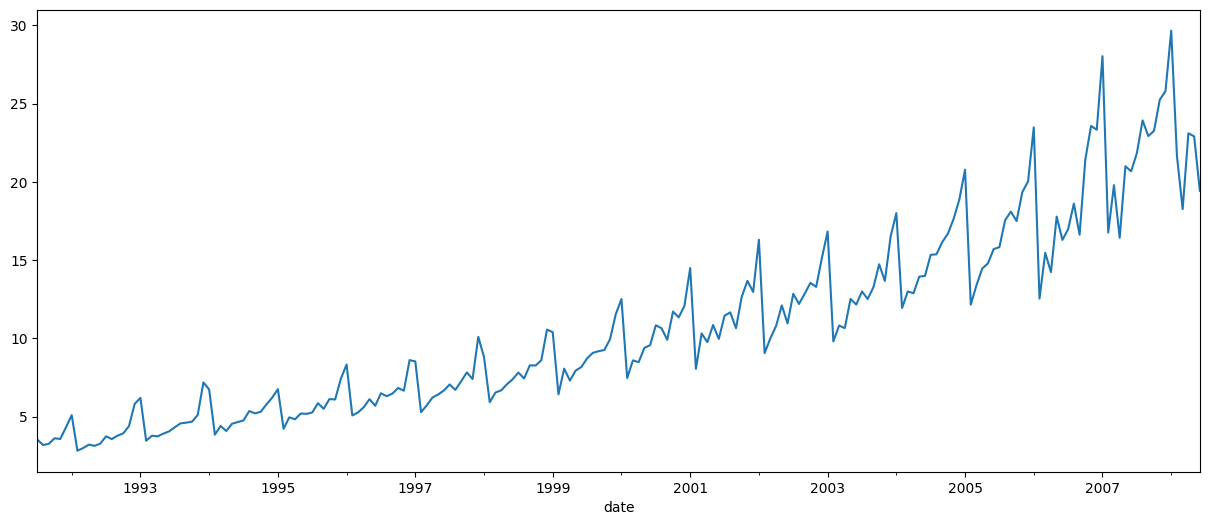

In [262]:
df['value'].plot(figsize=(15,6));

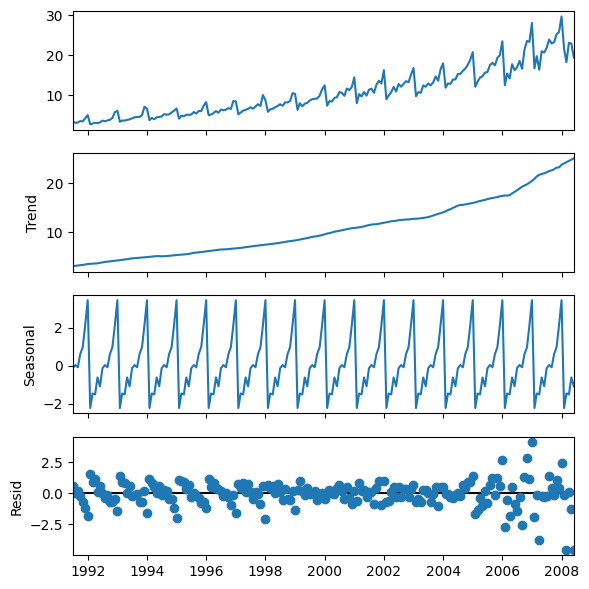

In [263]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_add = seasonal_decompose(df[['value']], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (6,6)})
result_add.plot();

In [264]:
X = df[['value']]
train = X[:-20]
test = X[-20:]

In [265]:
len(test)

20

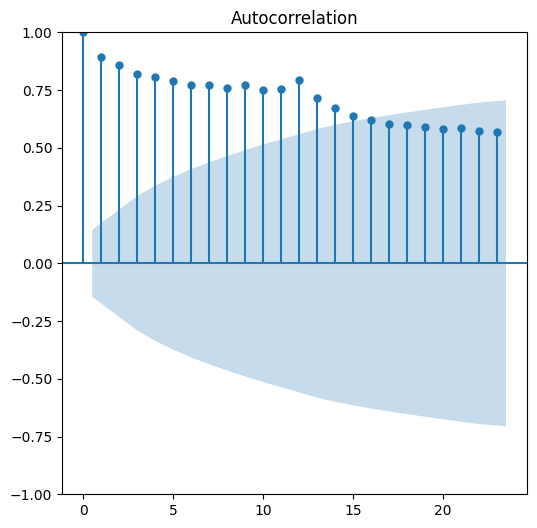

In [266]:
plot_acf(train);

Probemos el auto arima sin indicarle que hay componente de seasonality

In [267]:
model = auto_arima(train,
                    start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    trace=True,
                    stepwise=True)

print(model.aic())

predictions = model.predict(20)
print("mean_squared_error:", mean_squared_error(test, predictions))

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=698.391, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=764.142, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=739.394, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=708.405, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=762.612, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=700.332, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=700.362, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=699.998, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=736.404, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=695.600, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=697.194, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=697.299, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=700.821, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=699.306, Time=0.08 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, 

Ahora le añadimos el componente seasonality mediante el parametro `m`.

In [268]:
model = auto_arima(train,
                    start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    m = 12,
                    trace=True,
                    stepwise=True)

print(model.aic())

predictions = model.predict(20)
print("mean_squared_error:", mean_squared_error(test, predictions))

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=359.383, Time=0.37 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=480.967, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=391.380, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=366.538, Time=0.21 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=357.778, Time=0.21 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=367.053, Time=0.03 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=358.591, Time=0.98 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=361.813, Time=0.15 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=357.470, Time=2.43 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=356.290, Time=0.95 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=354.319, Time=0.60 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=353.117, Time=0.39 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=362.795, Time=0.38 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=378.264, Time=0.25 sec
 ARIMA(2,1,1)(2,1,0)[12]         

In [269]:
predictions

2006-11-01    18.411935
2006-12-01    22.337447
2007-01-01    23.985791
2007-02-01    14.694923
2007-03-01    17.793797
2007-04-01    15.554912
2007-05-01    19.914439
2007-06-01    17.435275
2007-07-01    19.484441
2007-08-01    19.793280
2007-09-01    18.919036
2007-10-01    22.729470
2007-11-01    20.464834
2007-12-01    24.066283
2008-01-01    25.277704
2008-02-01    16.770504
2008-03-01    18.944667
2008-04-01    18.007398
2008-05-01    20.873348
2008-06-01    19.578303
Freq: MS, dtype: float64

In [270]:
test.values

array([[23.575517  ],
       [23.334206  ],
       [28.038383  ],
       [16.763869  ],
       [19.792754  ],
       [16.427305  ],
       [21.000742  ],
       [20.681002  ],
       [21.83489   ],
       [23.93020353],
       [22.93035694],
       [23.26333992],
       [25.25003022],
       [25.80609   ],
       [29.665356  ],
       [21.654285  ],
       [18.264945  ],
       [23.107677  ],
       [22.91251   ],
       [19.43174   ]])

In [271]:
test

,value
date,
2006-11-01,23.575517
2006-12-01,23.334206
2007-01-01,28.038383
2007-02-01,16.763869
2007-03-01,19.792754
2007-04-01,16.427305
2007-05-01,21.000742
2007-06-01,20.681002
2007-07-01,21.834890


mean_squared_error: 10.176433524187129


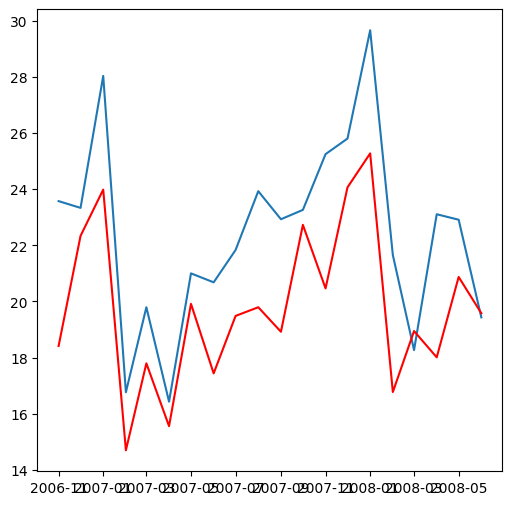

In [273]:
predictions = model.predict(len(test))
print("mean_squared_error:", mean_squared_error(test, predictions))
plt.plot(test)
plt.plot(predictions,color='red');

## Transformar dataset para poder predecir con otros modelos

In [146]:
df = pd.read_csv('data/a10.csv', parse_dates=['date'], index_col='date')
print(len(df))
df.head()

204


,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


In [147]:
df['value'].shift(1)

date
1991-07-01          NaN
1991-08-01     3.526591
1991-09-01     3.180891
1991-10-01     3.252221
1991-11-01     3.611003
                ...    
2008-02-01    29.665356
2008-03-01    21.654285
2008-04-01    18.264945
2008-05-01    23.107677
2008-06-01    22.912510
Name: value, Length: 204, dtype: float64

In [148]:
for i in range(12,0,-1):
    df['t-'+str(i)] = df['value'].shift(i)

df.dropna(inplace=True)
df

,value,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1
date,,,,,,,,,,,,,
1992-07-01,3.737851,3.526591,3.180891,3.252221,3.611003,3.565869,4.306371,5.088335,2.814520,2.985811,3.204780,3.127578,3.270523
1992-08-01,3.558776,3.180891,3.252221,3.611003,3.565869,4.306371,5.088335,2.814520,2.985811,3.204780,3.127578,3.270523,3.737851
1992-09-01,3.777202,3.252221,3.611003,3.565869,4.306371,5.088335,2.814520,2.985811,3.204780,3.127578,3.270523,3.737851,3.558776
1992-10-01,3.924490,3.611003,3.565869,4.306371,5.088335,2.814520,2.985811,3.204780,3.127578,3.270523,3.737851,3.558776,3.777202
1992-11-01,4.386531,3.565869,4.306371,5.088335,2.814520,2.985811,3.204780,3.127578,3.270523,3.737851,3.558776,3.777202,3.924490
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-02-01,21.654285,16.763869,19.792754,16.427305,21.000742,20.681002,21.834890,23.930204,22.930357,23.263340,25.250030,25.806090,29.665356
2008-03-01,18.264945,19.792754,16.427305,21.000742,20.681002,21.834890,23.930204,22.930357,23.263340,25.250030,25.806090,29.665356,21.654285
2008-04-01,23.107677,16.427305,21.000742,20.681002,21.834890,23.930204,22.930357,23.263340,25.250030,25.806090,29.665356,21.654285,18.264945


<Axes: >

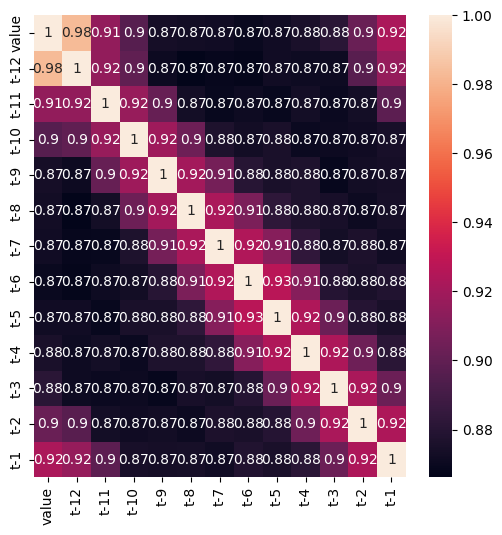

In [149]:
import seaborn as sns

sns.heatmap(df.corr(), annot=True)

Referencias:

* Hands on Time Series https://learning.oreilly.com/library/view/hands-on-time-series/9781484259924/
* Time Series con otros modelos https://learning.oreilly.com/videos/time-series-analysis/9781838640590/?autoplay=false
* Aquí cuenta bastante bien el tema de los parámetros ARIMA https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts
* Tutorial de ARIMA en vídeo https://www.youtube.com/watch?v=D9y6dcy0xK8
* Mas ARIMA con Python https://machinelearningmastery.com/make-sample-forecasts-arima-python/